In [ ]:
#import library
!pip install 'google-play-scraper'
!pip install sastrawi

import pandas as pd
import io
from google_play_scraper import Sort, reviews
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from pandas.io.parsers.python_parser import count_empty_vals
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, mean_absolute_percentage_error
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#scrapping data
result, continuation_token = reviews (
    'com.telkom.indihome.external',
    lang='id',
    country='id',
    sort=Sort.NEWEST,
    count=20000,
    filter_score_with=None #data yang diambil tidak bergantung rating
)

#membuat data frame hasil scraper
df=pd.DataFrame(np.array(result),columns=['review'])
df=df.join(pd.DataFrame(df.pop('review').tolist()))
df_data = pd.DataFrame(np.array(result),columns=['review'])
df_data = df_data.join(pd.DataFrame(df_data.pop('review').tolist()))
review = df_data[['userName', 'score','at', 'content']]
sorted_df = review.sort_values(by='at', ascending=False)
my_df = sorted_df[['userName', 'score','at', 'content']]
my_df.to_csv("ReviewMyIndihome.csv", index = False)

# menetapkan 1000 data ulasan selama 1 tahun
df1 = df[(df['at'] > '2022-06-01') & (df['at'] < '2023-05-31')]
df1 = df1[:1000]
df=df1[['userName','content','score','at']].copy()
df.to_csv("data terbaru.csv", index = False)

In [ ]:
#Case Folding
#ubah data ke string
df['content'] = df['content'].astype(str)
#case folding
df['case_folding'] = df['content'].apply(lambda x: x.lower())

In [ ]:
# cleaning (Remove Emoticon, Punctuation, Number)
def unusedchar(text):
  text = re.sub('[0-9]+', '', text) #removing number
  text = re.sub(r'[\n]+', '', text) #remove new line
  text = re.sub('\s+', ' ', text) #removing multiple whitespace
  text = text.replace('\\t', ' ').replace('\\n', ' ').replace('\\u', ' ').replace('\\', ' ')#remove tab, new line, and back slice
  text = re.sub(r"\b[a-zA-Z]\b", "", text) #removing single char
  text = re.sub(r'[^\w\s]', ' ', text) #remove puntuation $ emoji (remove all besides \w > word dan \s > space)
  return text

# remove unusedchar
df['remove_unusedchar'] = df['case_folding'].apply(lambda x:
                                                   unusedchar(x))

In [ ]:
# Normalisasi kata dengan KBBI
dict = {row[0] : row[1] for _, row in pd.read_csv("/content/kbbi new.txt",
 delimiter = "\t").iterrows()}

def kbbi(text):
    token = text.split()
    final_string = ' '.join(str(dict.get(word, word)) for word in token)
    return final_string

df['KBBI'] = df['remove_unusedchar'].apply(lambda x: kbbi(x))
df['clean'] = df['KBBI']
df = df[['clean']]
df.head()

,clean
11016,bagus aplikasi tapi terbaru terbaru tidak bisa...
11017,aplikasi burik masa saya masukkan nomor indiho...
11018,aplikasi myindihome sangat rekomendasi untuk p...
11019,aplikasi mantap bisa digunakan untuk melacak p...
11020,fup cepat habis cepat penuh akhirnya lambat se...


In [ ]:
#import kamus lexicon
kamus = pd.read_csv('//content/lexicon.txt',sep =':')
#mengatur index pada kamus yang ada
kamus = kamus.set_index('word')['weight'].to_dict()
#membaca kamus boosterword dengan nilai skor
bw = pd.read_csv('/content/boosterwords_id.txt',sep =':', names=['word','score'])
booster_words = bw.set_index('word')['score'].to_dict()
#import kamus negation
nw = pd.read_csv('/content/negatingword.txt',names=['word'])
negation_words = nw['word'].values.tolist()

In [ ]:
#menerapkan scoring sentimen
def sentiment_score(text):
    words = re.findall(r'\w+', text)
    score = 0
    prev_word_negated = False
    for i, word in enumerate(words):
        negated = False
        if i > 0 and words[i-1] in negation_words:
            negated = True
            prev_word_negated = True
        elif prev_word_negated:
            negated = True
            prev_word_negated = False
        if word in kamus:
            word_score = kamus[word]
            if word_score > 0 and i > 0 and words[i-1] in booster_words:
                word_score += booster_words[words[i-1]]
            elif word_score < 0 and i > 0 and words[i-1] in booster_words:
                word_score -= booster_words[words[i-1]]
            if negated:
                word_score *= -1
            score += word_score
    return score


In [ ]:
df['sentiment_score'] = df['clean'].apply(sentiment_score)

In [ ]:
#labeling sentimen berdasarkan skor
df['sentiment_class'] = np.where(df['sentiment_score'] >= 0, 'positive', 'negative')

In [ ]:
#remove stopword pada list token
txt_stopword = pd.read_csv("/content/stopword.txt",header = None)
def stopword(text):
    text = text.split()
    listStopword = txt_stopword[0][0].split(' ')

    text = [w for w in text if not w in listStopword]
    text = " ".join(text)
    return text

df['stopword'] = df['clean'].apply(lambda x: stopword(x))

In [ ]:
# Stemming dengan sastrawi
def Stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  text = text.split()
  hasil = [stemmer.stem(token) for token in text]
  hasil = " ".join(hasil)
  return hasil

df['stemming'] = df['stopword'].apply(Stemming)

In [ ]:
#proses tokenizing
def tokenizingText(ulasan):
  ulasan = word_tokenize(ulasan)
  return ulasan
df['token']= df['stemming'].apply(tokenizingText)
df.to_csv("token.csv", index = False)

In [ ]:
#mendefinisikan data frame token (data cleansing)
df = pd.read_csv('token.csv')

In [ ]:
#Perhitungan TF-IDF
tf=TfidfVectorizer()
text_tf=tf.fit_transform(df['token'])
text_tf

<994x777 sparse matrix of type '<class 'numpy.float64'>'
	with 7268 stored elements in Compressed Sparse Row format>

In [ ]:
#menampilkam nilai pembobotan TF-IDF
dfr = pd.DataFrame(text_tf.todense().T,
    index=tf.get_feature_names_out(),
    columns=[f'D{i+1}' for i in range(len(df['token']))])
dfr.to_csv("dfr_tfidf.csv", index=True)

In [ ]:
#merubah tipe data variabel
df=df.astype({'label':'category'})
df=df.astype({'token':'string'})
df.dtypes

clean                object
sentiment_score       int64
sentiment_class      object
label              category
stopword             object
stemming             object
token                string
dtype: object

In [ ]:
#Penentuan fitur dan target
X = text_tf
y = df['label']

#TRAIN TEST SPLIT 70:30

In [ ]:
#spliting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

In [ ]:
print('Number transformation X_train dataset', X_train.shape)
print('Number transformation y_train dataset', y_train.shape)
print('Number transformation X_test dataset', X_test.shape)
print('Number transformation y_tes dataset', y_test.shape)

Number transformation X_train dataset (695, 777)
Number transformation y_train dataset (695,)
Number transformation X_test dataset (299, 777)
Number transformation y_tes dataset (299,)


## MELIHAT DATA TRAIN DAN DATA TEST (OPSIONAL)

In [ ]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [ ]:
y_train

,label
752,1
327,1
793,1
928,1
543,1
...,...
106,1
270,1
860,1
435,1


In [ ]:
jumlah_positif = y_train[y_train['label'] == 1].shape[0]
jumlah_negatif = y_train[y_train['label'] == 0].shape[0]
print(f"Jumlah positif: {jumlah_positif}")
print(f"Jumlah negatif: {jumlah_negatif}")

Jumlah positif: 561
Jumlah negatif: 134


In [ ]:
y_test

,label
919,0
525,1
567,1
656,0
926,0
...,...
538,1
521,1
522,1
388,1


In [ ]:
y_test.to_excel("y_test.xlsx", index=True)

In [ ]:
jumlah_positif = y_test[y_test['label'] == 1].shape[0]
jumlah_negatif = y_test[y_test['label'] == 0].shape[0]
print(f"Jumlah positif: {jumlah_positif}")
print(f"Jumlah negatif: {jumlah_negatif}")

Jumlah positif: 233
Jumlah negatif: 66


# MEMBANGUN MODEL SVM DENGAN K FOLD CROSS VALIDATION


In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Data
X = pd.DataFrame(text_tf.toarray())  # Gantilah text_tf dengan data yang sesuai
y = pd.DataFrame(y)  # Gantilah y dengan target yang sesuai

# Tentukan berbagai nilai C dan gamma yang akan diuji
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [0.01, 0.1, 1, 10, 'auto'],
              'kernel': ['rbf']}

# Inisialisasi KFold Cross Validation dengan 10 fold
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=False)

# Inisialisasi model GridSearchCV
grid = GridSearchCV(SVC(random_state=42), param_grid, refit=True, verbose=3, cv=10)

# Grid Search CV untuk menemukan parameter terbaik
grid.fit(X_train, y_train.values.ravel())

hasil_grid_svm = pd.DataFrame(grid.cv_results_)
hasil_grid_svm.to_excel('hasil grid svm.xlsx')

# Model terbaik setelah grid search
best_model = grid.best_estimator_

# Inisialisasi list untuk menyimpan akurasi masing-masing fold pada data pelatihan
train_accuracies = []

# Iterasi melalui setiap fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]

    X_val_fold = X.iloc[val_idx]
    y_val_fold = y.iloc[val_idx]

    # Melatih model pada data pelatihan fold saat ini
    grid.best_estimator_.fit(X_train_fold, y_train_fold.values.ravel())

    # Prediksi data pelatihan fold saat ini
    y_train_pred = grid.best_estimator_.predict(X_train_fold)

    # Mengukur akurasi dari pelatihan model pada data pelatihan fold saat ini
    train_accuracy = accuracy_score(y_train_fold, y_train_pred)
    train_accuracies.append(train_accuracy)

    # Menampilkan akurasi pelatihan untuk masing-masing fold
    print(f"Fold {fold + 1}: Train Accuracy = {train_accuracy:.2f}")

# Menampilkan rata-rata akurasi dari semua fold pada data pelatihan
print("\nAverage Train Accuracy on All Folds:", sum(train_accuracies) / num_folds)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END ...C=0.01, gamma=0.01, kernel=rbf;, score=0.814 total time=   0.3s
[CV 2/10] END ...C=0.01, gamma=0.01, kernel=rbf;, score=0.800 total time=   0.1s
[CV 3/10] END ...C=0.01, gamma=0.01, kernel=rbf;, score=0.800 total time=   0.3s
[CV 4/10] END ...C=0.01, gamma=0.01, kernel=rbf;, score=0.800 total time=   0.2s
[CV 5/10] END ...C=0.01, gamma=0.01, kernel=rbf;, score=0.800 total time=   0.2s
[CV 6/10] END ...C=0.01, gamma=0.01, kernel=rbf;, score=0.812 total time=   0.1s
[CV 7/10] END ...C=0.01, gamma=0.01, kernel=rbf;, score=0.812 total time=   0.2s
[CV 8/10] END ...C=0.01, gamma=0.01, kernel=rbf;, score=0.812 total time=   0.2s
[CV 9/10] END ...C=0.01, gamma=0.01, kernel=rbf;, score=0.812 total time=   0.2s
[CV 10/10] END ..C=0.01, gamma=0.01, kernel=rbf;, score=0.812 total time=   0.2s
[CV 1/10] END ....C=0.01, gamma=0.1, kernel=rbf;, score=0.814 total time=   0.2s
[CV 2/10] END ....C=0.01, gamma=0.1, kernel=rb

In [ ]:
#Menunjukkan nilai alpha, b untuk model grid
Grid_best_param = grid.best_estimator_
alphasgrid = np.abs(Grid_best_param.dual_coef_)
print("intercept:", Grid_best_param.intercept_)
print("dual coef:", Grid_best_param.dual_coef_)
print("alpha:", alphasgrid)

intercept: [0.09879681]
dual coef: [[-1.00000000e+01 -2.87026647e+00 -1.00000000e+01 -1.00000000e+01
  -1.00000000e+01 -1.00000000e+01 -6.38021969e+00 -3.91871349e+00
  -2.82032282e+00 -7.45899514e-01 -6.86094772e+00 -9.40910846e+00
  -1.00000000e+01 -7.13649012e+00 -6.02708672e+00 -7.68973011e-01
  -1.00000000e+01 -1.00000000e+01 -1.00000000e+01 -2.55418187e+00
  -4.79848005e+00 -4.91995552e+00 -6.84308389e+00 -1.00000000e+01
  -4.37062025e+00 -1.01887957e+00 -5.10702394e-01 -8.53243586e+00
  -5.20174769e+00 -2.89908538e+00 -3.75004278e+00 -1.31411575e+00
  -1.53344172e+00 -6.43487506e+00 -1.20053035e-01 -4.03690279e+00
  -1.00000000e+01 -5.14541129e+00 -4.85861543e+00 -3.90589979e+00
  -3.96586554e-01 -5.58214191e+00 -2.64405305e+00 -8.89896292e+00
  -4.17840289e+00 -1.00000000e+01 -3.53574148e+00 -6.10278350e+00
  -9.98688052e+00 -1.76796725e+00 -3.48140032e+00 -1.74388343e+00
  -8.57566260e+00 -4.68815986e+00 -1.46534556e+00 -7.74105951e+00
  -1.00000000e+01 -2.43789020e+00 -3.7403

In [ ]:
best_params = grid.best_estimator_.get_params()
print(f'Best params:')
for param in param_grid:
  print(f'\t{param}: {best_params[param]}')

Best params:
	C: 10
	gamma: 0.1
	kernel: rbf


In [ ]:
Grid_best_param.dual_coef_.shape


(1, 295)

In [ ]:
alphasgrid.shape

(1, 295)

##EVALUASI MODEL SVM TERHADAP DATA TEST

In [ ]:


# Menguji model terbaik dengan data train
y_train_pred = best_model.predict(X_train)

# Menghitung metrik pada data train
train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_kappa = cohen_kappa_score(y_train, y_train_pred)

# Menampilkan metrik pada data train
print("Metrics on Train Data:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Recall: {train_recall:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"F1-Score: {train_f1:.2f}")
print(f"Kappa Statistic: {train_kappa:.2f}")
print(classification_report(y_train, y_train_pred, zero_division=0))
print(confusion_matrix(y_train,y_train_pred))
print()

# Menguji model terbaik dengan data test
y_pred = best_model.predict(X_test)

# Menghitung metrik pada data test
test_accuracy = accuracy_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_kappa = cohen_kappa_score(y_test, y_pred)

# Menampilkan metrik pada data test
print("Metrics on Test Data:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"F1-Score: {test_f1:.2f}")
print(f"Kappa Statistic: {test_kappa:.2f}")
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test,y_pred))
print()



Metrics on Train Data:
Accuracy: 0.99
Recall: 1.00
Precision: 0.99
F1-Score: 0.99
Kappa Statistic: 0.97
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       164
           1       0.99      1.00      0.99       731

    accuracy                           0.99       895
   macro avg       0.99      0.98      0.98       895
weighted avg       0.99      0.99      0.99       895

[[157   7]
 [  2 729]]

Metrics on Test Data:
Accuracy: 0.93
Recall: 0.97
Precision: 0.95
F1-Score: 0.96
Kappa Statistic: 0.80
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        66
           1       0.95      0.97      0.96       233

    accuracy                           0.93       299
   macro avg       0.91      0.89      0.90       299
weighted avg       0.93      0.93      0.93       299

[[ 54  12]
 [  8 225]]



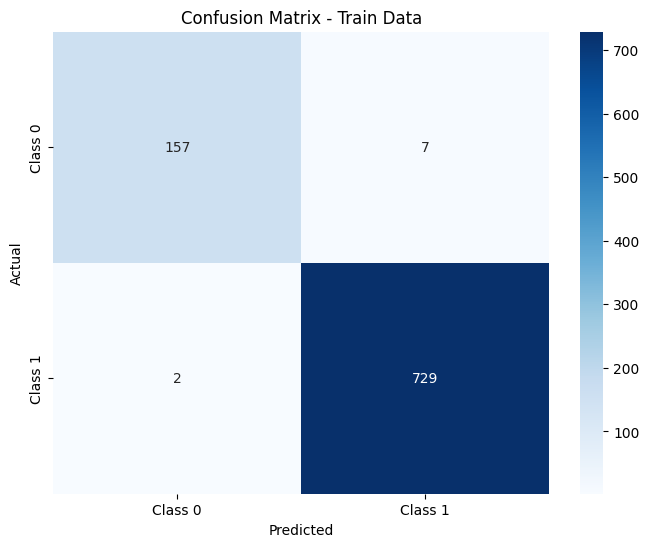

In [ ]:
# Menampilkan confusion matrix data train
y_train_pred = best_model.predict(X_train)
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


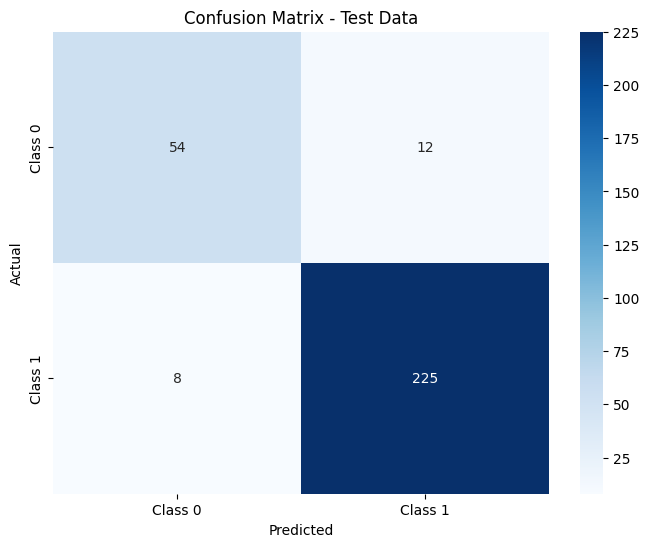

In [ ]:
# Menampilkan confusion matrix data test
conf_matrix_test = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y_pred

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
len(y_pred)

299

# MEMBANGUN MODEL NBC DENGAN K FOLD CROSS VALIDATION


In [ ]:
# Data
X = pd.DataFrame(text_tf.toarray())
y = pd.DataFrame(y)

# Split data menjadi train (70%) dan test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Inisialisasi model NBC dengan KFold cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=False)

# List untuk menyimpan metrik hasil setiap fold
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Iterasi melalui setiap fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]

    X_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]

    # Inisialisasi model Naive Bayes
    nb_model = MultinomialNB()

    # Melatih model NBC
    nb_model.fit(X_train_fold, y_train_fold.values.ravel())

    # Prediksi label pada data validasi
    y_val_pred = nb_model.predict(X_val)

    # Menghitung metrik pada data validasi
    fold_accuracy = accuracy_score(y_val, y_val_pred)
    fold_precision = precision_score(y_val, y_val_pred)
    fold_recall = recall_score(y_val, y_val_pred)
    fold_f1 = f1_score(y_val, y_val_pred)

    # Menyimpan metrik dalam list
    accuracies.append(fold_accuracy)
    precisions.append(fold_precision)
    recalls.append(fold_recall)
    f1_scores.append(fold_f1)

    print(f"Fold {fold + 1}: Accuracy = {fold_accuracy:.2f}, Precision = {fold_precision:.2f}, Recall = {fold_recall:.2f}, F1-Score = {fold_f1:.2f}")

# Menampilkan rata-rata metrik dari seluruh fold
print("Average Metrics across all folds:")
print(f"Accuracy: {np.mean(accuracies):.2f}")
print(f"Precision: {np.mean(precisions):.2f}")
print(f"Recall: {np.mean(recalls):.2f}")
print(f"F1-Score: {np.mean(f1_scores):.2f}")


Fold 1: Accuracy = 0.83, Precision = 0.82, Recall = 1.00, F1-Score = 0.90
Fold 2: Accuracy = 0.87, Precision = 0.86, Recall = 1.00, F1-Score = 0.93
Fold 3: Accuracy = 0.94, Precision = 0.95, Recall = 0.99, F1-Score = 0.97
Fold 4: Accuracy = 0.92, Precision = 0.91, Recall = 1.00, F1-Score = 0.96
Fold 5: Accuracy = 0.94, Precision = 0.93, Recall = 1.00, F1-Score = 0.97
Fold 6: Accuracy = 0.96, Precision = 0.96, Recall = 1.00, F1-Score = 0.98
Fold 7: Accuracy = 0.87, Precision = 0.86, Recall = 1.00, F1-Score = 0.93
Fold 8: Accuracy = 0.83, Precision = 0.82, Recall = 1.00, F1-Score = 0.90
Fold 9: Accuracy = 0.79, Precision = 0.78, Recall = 0.99, F1-Score = 0.87
Fold 10: Accuracy = 0.62, Precision = 0.64, Recall = 0.89, F1-Score = 0.75
Average Metrics across all folds:
Accuracy: 0.86
Precision: 0.85
Recall: 0.99
F1-Score: 0.91


##EVALUASI MODEL NBC TERHADAP DATA TEST

In [ ]:
# Melatih model NBC pada seluruh data train
nb_model.fit(X_train, y_train.values.ravel())

# Menguji model terbaik dengan data train
y_train_pred = nb_model.predict(X_train)

# Menghitung metrik pada data train
train_accuracy = accuracy_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)
train_kappa = cohen_kappa_score(y_train, y_train_pred)

# Menampilkan metrik pada data train
print("Metrics on Train Data:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Recall: {train_recall:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"F1-Score: {train_f1:.2f}")
print(f"Kappa Statistic: {train_kappa:.2f}")
print(classification_report(y_train, y_train_pred, zero_division=0))
print(confusion_matrix(y_train,y_train_pred))
print()


# Menguji model terhadap data test
y_test_pred = nb_model.predict(X_test)

# Menghitung metrik pada data test
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_kappa = cohen_kappa_score(y_test, y_test_pred)

# Menampilkan metrik pada data test
print("Metrics on Test Data:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1-Score: {test_f1:.2f}")
print(f"Kappa Statistic: {train_kappa:.2f}")
print(classification_report(y_test, y_test_pred, zero_division=0))
print(confusion_matrix(y_test,y_test_pred))
print()


Metrics on Train Data:
Accuracy: 0.89
Recall: 1.00
Precision: 0.88
F1-Score: 0.94
Kappa Statistic: 0.57
              precision    recall  f1-score   support

           0       1.00      0.46      0.63       134
           1       0.88      1.00      0.94       561

    accuracy                           0.89       695
   macro avg       0.94      0.73      0.78       695
weighted avg       0.91      0.89      0.88       695

[[ 61  73]
 [  0 561]]

Metrics on Test Data:
Accuracy: 0.83
Precision: 0.82
Recall: 1.00
F1-Score: 0.90
Kappa Statistic: 0.32
              precision    recall  f1-score   support

           0       0.94      0.24      0.39        66
           1       0.82      1.00      0.90       233

    accuracy                           0.83       299
   macro avg       0.88      0.62      0.64       299
weighted avg       0.85      0.83      0.79       299

[[ 16  50]
 [  1 232]]



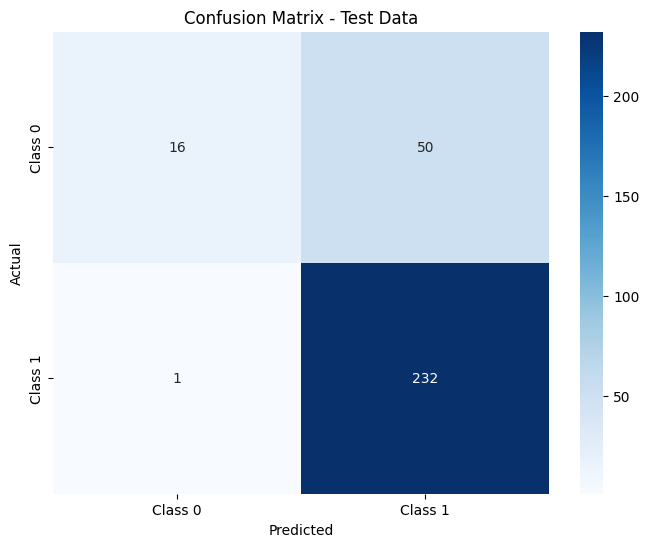

In [ ]:
# Menampilkan confusion matrix data test
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



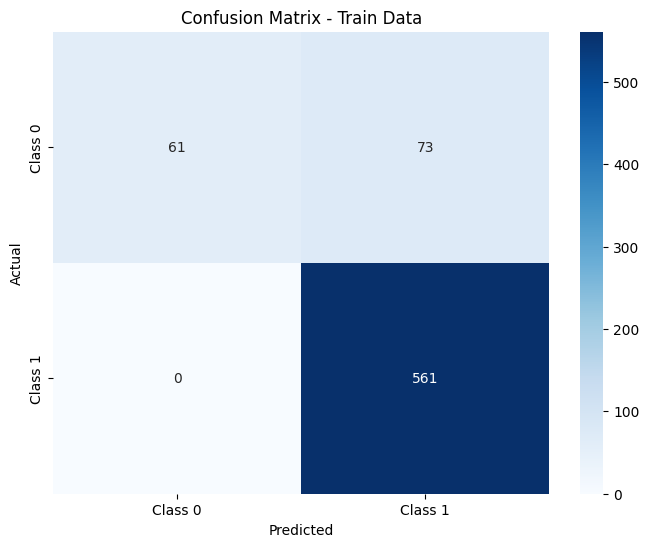

In [ ]:
# Menampilkan confusion matrix data train
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix - Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#WORDCLOUD

In [ ]:
#mendefinisikan data ulasan hasil pre-processing beserta pelabelan
ulasan = pd.read_csv('data ulasan.csv')
ulasan

,sentiment_class,label,content
0,positive,1,bagus aplikasi baru baru transaksi pakai lin...
1,negative,0,aplikasi burik masuk nomor indihome bilang d...
2,positive,1,aplikasi myindihome rekomendasi guna wifi biay...
3,positive,1,aplikasi mantap guna lacak guna erti bulan giga
4,positive,1,fup cepat habis cepat penuh lambat moga baik l...
...,...,...,...
989,positive,1,rekomendasi banget pakai indihome harga jangka...
990,positive,1,nyaman pakai indihome ditawarin ganti langsung...
991,negative,0,menu adu layan klik adu ganggu
992,positive,1,jos


In [ ]:
# mengambil seluruh kata pada kolom 'ulasan'
words = ' '.join(ulasan['content'].tolist())

# mengelompokkan kata berdasarkan nilai pada kolom 'sentimen'
positive_words = ' '.join(ulasan[ulasan['sentiment_class'] == 'positive']['content'].tolist())
negative_words = ' '.join(ulasan[ulasan['sentiment_class'] == 'negative']['content'].tolist())

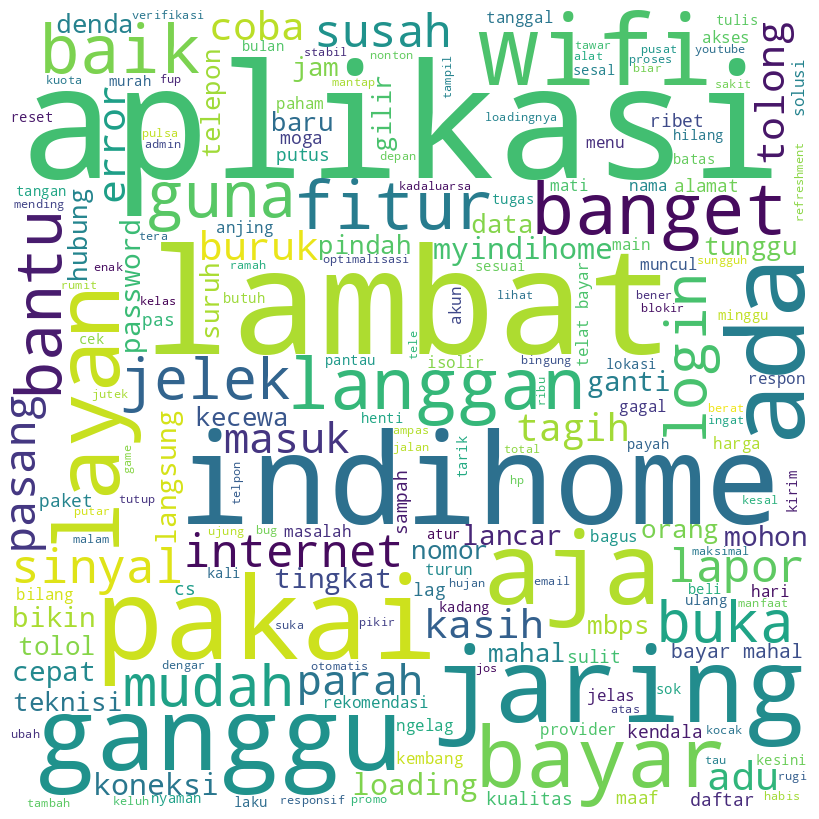

In [ ]:
# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(negative_words)

# Menampilkan WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

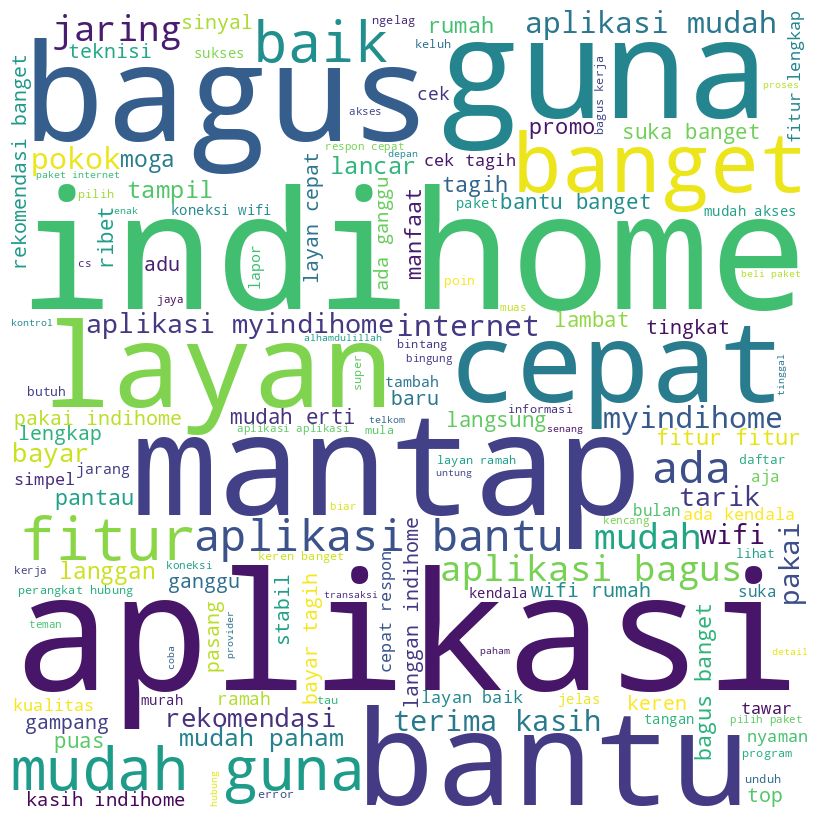

In [ ]:
# Membuat objek WordCloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate(positive_words)

# Menampilkan WordCloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()